# Neural network for changepoint detection algorithm

## Mathematical background

### Sequentially learning neural networks

Consider a time series $x_1,x_2,...$ where $x_t \in \mathbb{R}^d$ and its auto-regressive form $X_k, X_{k+1}$ as suggested by <a href="https://arxiv.org/abs/1203.0453">Liu et al. (2013)</a> where $X_t \in \mathbb{R}^{kd}$ with 
$$
X_t = \left[ \begin{array}{c}
    x_t^{\intercal} \\
    x_{t-1}^{\intercal} \\
    \vdots \\
    x_{t-k+1}^{\intercal}
\end{array} \right].
$$
Note that the auto-regressive form and the observed time series are equivalent when $k=1$.

The main idea of the neural network model is to compare two mini-batches of observations $X_{t}$ and $X_{t-l}$ lagged with some parameter $l$. Indeed, if both mini-batches have the same distribution, then there is no changepoint to be detected. Therefore, the idea of this method is to sequentially compare the distribution of mini-batches in order to determine if a changepoint has occurred or not.

Instead of comparing directly $X_{t}$ and $X_{t-l}$, we will here compare mini-batches $\mathcal{X}_{t}$ and $\mathcal{X}_{t-l}$ where $\mathcal{X}_t$ is defined as
$$
\mathcal{X}_t = \{ X_t, X_{t-1}, ..., X_{t-n+1} \},
$$
where $n$ is another windowing parameter. In practice, we would prefer to use $n \ll l$ to detect changepoints as fast as possible.

A classification-based neural network model $f_{\theta}$ is then trained to check if mini-batches $\mathcal{X}_t$ and $\mathcal{X}_{t-l}$ are sampled from the same distribution using binary cross-entropy loss function $\mathcal{L}(\mathcal{X}_{t-l}, \mathcal{X}_{t})$
$$
\mathcal{L}(\mathcal{X}_{t-l}, \mathcal{X}_{t}) = - \frac{1}{n} \sum_{X \in \mathcal{X}_{t-l}} \log \{ 1 - f_{\theta}(X) \} - \frac{1}{n} \sum_{X \in \mathcal{X}_{t}} \log \{ f_{\theta}(X) \}.
$$

Observations in the lagged mini-batch $\mathcal{X}_{t-l}$ are considered as the negative class and observations in the current mini-batch $\mathcal{X}_{t}$ are considered as the positive class. Hence, the model would process sequentially each pair of mini-batches and update its parameters with time. Information of previous batches is \textit{contained} into the network weights, which makes the algorithm computationally efficient.

Therefore, the neural network $f_{\theta}$ can be used to compare distributions of observations in each mini-batch. A \textit{dissimilarity measure} $D(\mathcal{X}_{t-l}, \mathcal{X}_{t})$ is computed sequentially as the Kullback-Leibler divergence
$$
D(\mathcal{X}_{t-l}, \mathcal{X}_{t}) = \frac{1}{n} \sum_{X \in \mathcal{X}_{t-l}} \log \left\{ \frac{1 - f_{\theta}(X)}{f_{\theta}(X)} \right\} + \frac{1}{n} \sum_{X \in \mathcal{X}_{t}} \log \left\{ \frac{f_{\theta}(X)}{1 - f_{\theta}(X)} \right\}.
$$

This dissimilarity measure may be noisy depending on the nature of the data. To tackle this issue, we introduce a <i>rolled</i> dissimilarity measure $d(\mathcal{X}_{t-l}, \mathcal{X}_{t})$ such that
$$
\begin{aligned}
d(\mathcal{X}_{0}, \mathcal{X}_{l}) &= 0, \\
d(\mathcal{X}_{t+1-l}, \mathcal{X}_{t+1}) &= d(\mathcal{X}_{t-l}, \mathcal{X}_{t}) + \frac{1}{l} \Big( D(\mathcal{X}_{t-l}, \mathcal{X}_{t}) - D(\mathcal{X}_{t-l-n}, \mathcal{X}_{t-n}) \Big).
\end{aligned}
$$
Hence, once mini-batches have the same distribution, values of $d$ are close to zero whereas when they have different distributions, values of $d$ are positive. All steps are combined in an algorithm that can be run online and sequentially after receiving each new observation.

### Extending to online changepoint detection

The method described above and introduced by <a href="https://arxiv.org/abs/2010.01388">Hushchyn et al. (2020)</a> has some drawbacks in online context (Master Thesis). We propose to extend it by designing modified versions of the EWMA algorithm applied to the rolling dissimilarity measure $d$. One is designed to detect increases only and adding a timeout, the other is detecting bumps (sequences of increase and decrease). Therefore, we show how we can reduce the problem of online changepoint detection in multivariate data to a problem of univariate increase or bump detection. 

## Neural network in `ocpdet`

Install `ocpdet` package by running the command line: `pip install ocpdet` and import NeuralNetwork as

In [1]:
from ocpdet import NeuralNetwork

The main advantage of neural networks for changepoint detection algorithm is that it can be used for multivariate data, such as images. We will here show an example of online changepoint detection based on deep learning for computer vision on the MNIST dataset.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets

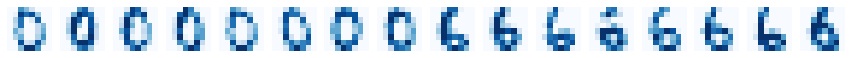

In [3]:
np.random.seed(42)

def create_digit_sequence(first_digit, second_digit):
    digits = datasets.load_digits()
    digits_before = digits["data"][digits["target"] == first_digit]
    digits_after = digits["data"][digits["target"] == second_digit]
    data_before = digits_before[np.random.choice(len(digits_before), (500,))]
    data_after = digits_after[np.random.choice(len(digits_after), (500,))]
    return np.concatenate((data_before, data_after))

data = create_digit_sequence(0, 6)

sample = data[np.concatenate([np.random.randint(0, 500, 8), np.random.randint(500, 1000, 8)])]
fig, axs = plt.subplots(1, 16, figsize=(15, 1))
for i, image in enumerate(sample):
    axs[i].imshow(image.reshape((8, 8)), cmap="Blues")
    axs[i].axis("off")
plt.show()

The neural network algorithm is implemented as a `Class` in `ocpdet` to give high flexibility in its parameters. Parameters by default would perfectly run on a univariate stream. To make the algorithm work on multivariate data such as $8 \times 8$ images, we provide the following convolutional neural network architecture with width and height of the input layer directly related to $k$ and $n$ and $8 \times 8 = 64$ channels.

In [4]:
tf.random.set_seed(42)

f = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 5, activation="elu", input_shape=(10, 10, 64), 
                           kernel_initializer=tf.keras.initializers.GlorotNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, 5, activation="elu",
                           kernel_initializer=tf.keras.initializers.GlorotNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal())
])

model = NeuralNetwork(k=10, n=10, lag=100, f=f, r=0.1, L=3, burnin=100, method="increase", timeout=100)

2023-02-11 18:42:01.933456: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can now process this data stream using the NeuralNetwork object `model` that we created.

In [5]:
model.process(data)

100%|█████████████████████████████████████████████████████████████████████████████████| 881/881 [00:22<00:00, 38.68it/s]


We can now retrieve detected changepoints using the `changepoints` attribute of the `model` object.

In [6]:
model.changepoints

array([538])

The true change occurred at time $t = 500$, so this is not too bad taking into account that data is multivariate and that the neural network was not pre-trained at all on image or MNIST data before. The `NeuralNetwork` object also brings flexibility and access to the algorithm statistics: the Kullback-Leibler divergence $D_{KL}$, the dissimilarity function $d$, and the EWMA statistics $Z$, $\mu$ and $\sigma_Z$.

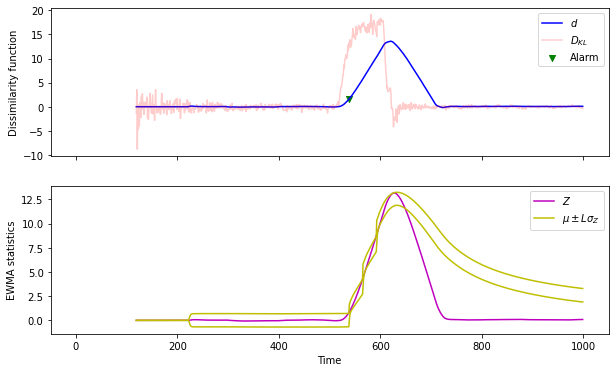

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

ax1.plot(range(len(data) - len(model.dissimilarity), len(data)), model.dissimilarity, c="b", label="$d$")
ax1.plot(range(len(data) - len(model.dissimilarity), len(data)), model.divergence, alpha=.2, c="r", label="$D_{KL}$")
ax1.scatter(model.changepoints, model.dissimilarity[model.changepoints - (len(data) - len(model.dissimilarity))],
            c="g", marker="v", label="Alarm")
ax1.legend()
ax1.set_ylabel("Dissimilarity function")

ax2.plot(range(len(data) - len(model.dissimilarity), len(data)), model.Z, c="m", label="$Z$")
ax2.plot(range(len(data) - len(model.dissimilarity), len(data)), 
         np.asarray(model.mu) + model.L * np.asarray(model.sigma_Z), c="y", label="$\mu \pm L \sigma_Z$")
ax2.plot(range(len(data) - len(model.dissimilarity), len(data)), 
         np.asarray(model.mu) - model.L * np.asarray(model.sigma_Z), c="y")
ax2.legend()
ax2.set_xlim(-50, 1050)
ax2.set_xlabel("Time")
ax2.set_ylabel("EWMA statistics")

plt.show()

The algorithm also performs well on univariate data as for more classical methods in this package. For example below is shown an example on a univariate stream using the NeuralNetwork algorithm.

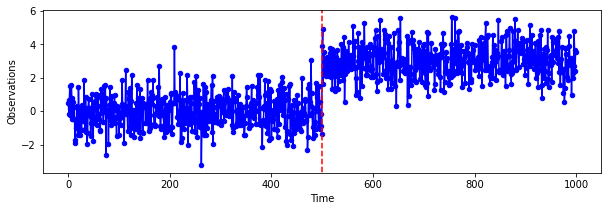

In [8]:
np.random.seed(42)

data = np.concatenate([
    np.random.normal(loc=0., scale=1., size=(500,)),
    np.random.normal(loc=3., scale=1., size=(500,))
])

plt.figure(figsize=(10, 3))
plt.scatter(range(0, len(data)), data, c="b", s=20)
plt.plot(range(0, len(data)), data, c="b")
plt.xlabel("Time")
plt.ylabel("Observations")
plt.axvline(500, min(data), max(data), color="r", linestyle="--")
plt.show()

We can use the neural network architecture by default here since the stream is univariate by specifying `f = None`.

In [9]:
model = NeuralNetwork(k=5, n=10, lag=60, f=None, r=.1, L=2, burnin=100, method="increase", timeout=100)

In [10]:
model.process(data)

100%|█████████████████████████████████████████████████████████████████████████████████| 926/926 [00:24<00:00, 38.25it/s]


In [11]:
model.changepoints

array([540])

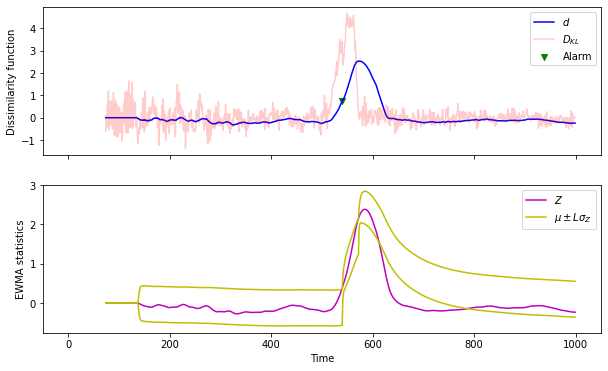

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

ax1.plot(range(len(data) - len(model.dissimilarity), len(data)), model.dissimilarity, c="b", label="$d$")
ax1.plot(range(len(data) - len(model.dissimilarity), len(data)), model.divergence, alpha=.2, c="r", label="$D_{KL}$")
ax1.scatter(model.changepoints, model.dissimilarity[model.changepoints - (len(data) - len(model.dissimilarity))],
            c="g", marker="v", label="Alarm")
ax1.legend()
ax1.set_ylabel("Dissimilarity function")

ax2.plot(range(len(data) - len(model.dissimilarity), len(data)), model.Z, c="m", label="$Z$")
ax2.plot(range(len(data) - len(model.dissimilarity), len(data)), 
         np.asarray(model.mu) + model.L * np.asarray(model.sigma_Z), c="y", label="$\mu \pm L \sigma_Z$")
ax2.plot(range(len(data) - len(model.dissimilarity), len(data)), 
         np.asarray(model.mu) - model.L * np.asarray(model.sigma_Z), c="y")
ax2.legend()
ax2.set_xlim(-50, 1050)
ax2.set_xlabel("Time")
ax2.set_ylabel("EWMA statistics")

plt.show()